# Imports

Repeating attempt to measure noise on UFM using RFSoC!

## shawnhammer startup

Started up by running `rfsochammer` in a terminal. Running on slot 3, rogue version /home/cryo/docker/smurf/stable/v8.0.0-rc3_rfsoc, and experiment.cfg cfg_files/b33/experiment_b33_rfc1-2_C05-40_s4_lbOnlyBay0_fiber
.cfg. `pysmurf` docker  /home/cryo/docker/pysmurf/dev/v8.0.0-rc3_rfsoc, tag v8.0.0-rc3 but with zcu208-devel merged into it.  `setup()`.  DR MXC is being servo'd to 100mK.

Locked to external timing system via fiber.

Rogue server configured to use PCIe card.  Running PCIe card software driver version 5.19.3, PCIe card firmware version d89c87b6b29ddc5dab8a3be374e749725d598399.

## Load, check, and record configuration

In [25]:
epics_prefix="smurf_server_s4"
config_file=os.path.abspath("/usr/local/src/pysmurf/cfg_files/b33/experiment_b33_rfc1-2_C05-40_s4_lbOnlyBay0_backplane.cfg")
Samc = pysmurf.client.SmurfControl(epics_root=epics_prefix,cfg_file=config_file,setup=False,make_logfile=False,shelf_manager="shm-smrf-sp01")

RFSoC

In [1]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
import yaml
import time
import pickle as pkl
import os
import numpy as np
from matplotlib import cm
from scipy.signal import welch,periodogram
import pandas as pd
import glob
from scipy.optimize import curve_fit
from scipy import signal

import pysmurf.client
import matplotlib.pylab as plt
import numpy as np
import sys
import os
epics_prefix="smurf_server_s3"
config_file=os.path.abspath("/usr/local/src/pysmurf/cfg_files/b33/experiment_b33_rfc1-2_C05-40_s4_lbOnlyBay0_fiber.cfg")
S = pysmurf.client.SmurfControl(epics_root=epics_prefix,cfg_file=config_file,setup=False,make_logfile=False,shelf_manager="shm-smrf-sp01")

[ 2024-08-06 22:49:48 ]  ERROR : band 0 is present in pysmurf cfg file, but its bay is not enabled!
[ 2024-08-06 22:49:48 ]  ERROR : band 1 is present in pysmurf cfg file, but its bay is not enabled!
[ 2024-08-06 22:49:48 ]  ERROR : band 2 is present in pysmurf cfg file, but its bay is not enabled!
[ 2024-08-06 22:49:48 ]  ERROR : band 3 is present in pysmurf cfg file, but its bay is not enabled!


These errors are expected.

In [9]:
S.setup()

[ 2024-08-06 22:50:56 ]  System already configured, but will configure again since force_configure=True.
[ 2024-08-06 22:50:56 ]  Setting up...
[ 2024-08-06 22:50:56 ]  caput smurf_server_s3:AMCc:ReadAll 1
[ 2024-08-06 22:50:59 ]  Waiting 20.00 seconds after...
[ 2024-08-06 22:51:19 ]  Done waiting.
[ 2024-08-06 22:51:19 ]  caget smurf_server_s3:AMCc:SmurfApplication:SmurfVersion
[ 2024-08-06 22:51:19 ]  8.0.0-rc3+12.gc1067044
[ 2024-08-06 22:51:19 ]  caput smurf_server_s3:AMCc:setDefaults 1
[ 2024-08-06 22:51:32 ]  caget smurf_server_s3:AMCc:SmurfApplication:ConfiguringInProgress
[ 2024-08-06 22:51:32 ]  False
[ 2024-08-06 22:51:32 ]  caget smurf_server_s3:AMCc:SmurfApplication:SystemConfigured
[ 2024-08-06 22:51:32 ]  True
[ 2024-08-06 22:51:32 ]  System configuration finished after 13 seconds. The final state was True.
[ 2024-08-06 22:51:32 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:iqSwapIn 0
[ 2024-08-06 22:51:32 ]  caput smurf_server_s3:AMCc:Fpga

True

Is timing up?

In [10]:
S.get_timing_link_up()

1

What versions of everything are we running?

In [2]:
pysmurf.__version__

'8.0.0-rc3+12.gc1067044'

In [3]:
!git branch

* (HEAD detached from v8.0.0-rc3)
  zcu208-devel


In [4]:
S._caget(f'{epics_prefix}:AMCc:RogueVersion', as_string=True)

'v4.11.11'

In [5]:
S._caget(f'{epics_prefix}:AMCc:SmurfApplication:SmurfVersion', as_string=True)

'8.0.0-rc3+12.gc1067044'

In [6]:
S._caget(f'{epics_prefix}:AMCc:SmurfApplication:StartupArguments', as_string=True)

'-g -w smurf_server_s3 -l 1 -d /tmp/fw/smurf_cfg/defaults/defaults_rfsoc_zcu208.yml -e smurf_server_s3 --disable-bay0 --disable-bay1 -a 10.0.1.103'

In [7]:
S.get_fpga_git_hash_short()

'e54bbcc'

Check timing configuration

In [52]:
print(S.get_timing_mode())

fiber


In [51]:
S.set_downsample_mode('external')
S.set_downsample_factor(20)

## Bias RF amps for B33 DR RF chain #2

Biasing the RF amplifiers through the AMC SMuRF system.

## Calibrate phase delay

This function tries to set the UC/DC attenuators, so will have to do it manually.

## Find resonator frequencies (`find_freqs`)

First in loop back with a short coax.

[ 2024-08-06 23:00:56 ]  Sweeping across frequencies 4000.0MHz to 4500.0MHz
[ 2024-08-06 23:00:56 ]  Working on band 0
[ 2024-08-06 23:01:26 ]  serial find freq complete ; etaScanInProgress = 0


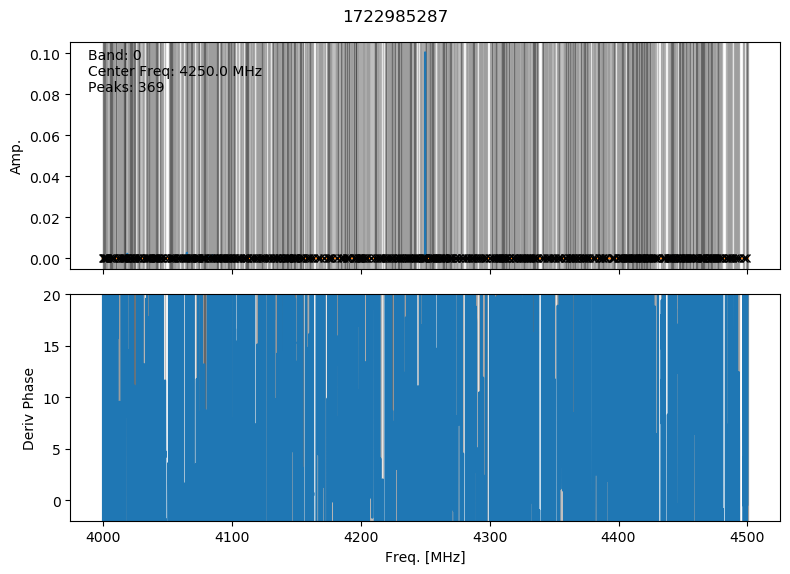

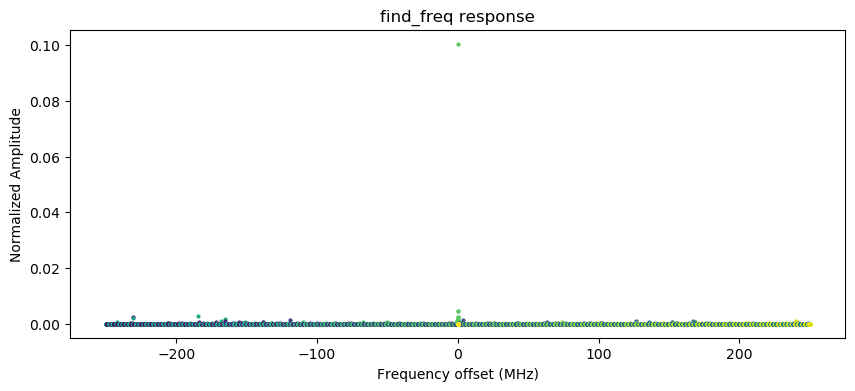

[ 2024-08-06 23:01:34 ]  Sweeping across frequencies 5000.0MHz to 5500.0MHz
[ 2024-08-06 23:01:34 ]  Working on band 2
[ 2024-08-06 23:02:04 ]  serial find freq complete ; etaScanInProgress = 0


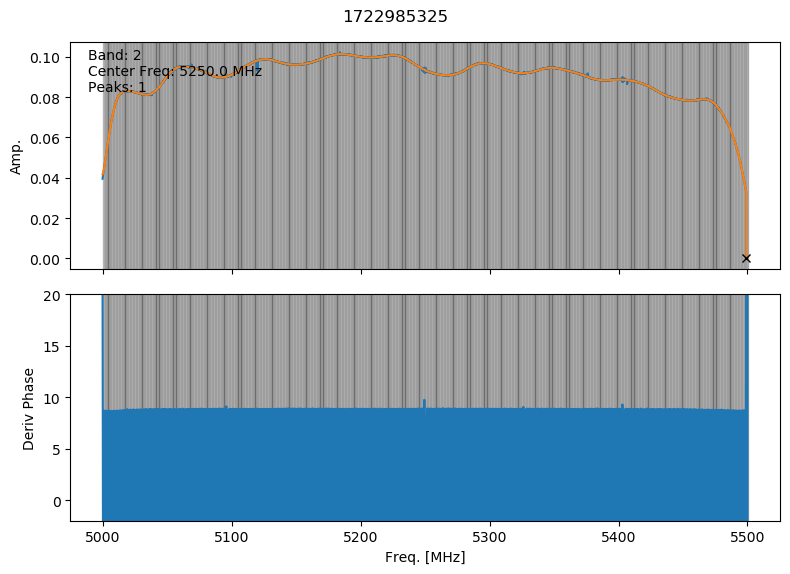

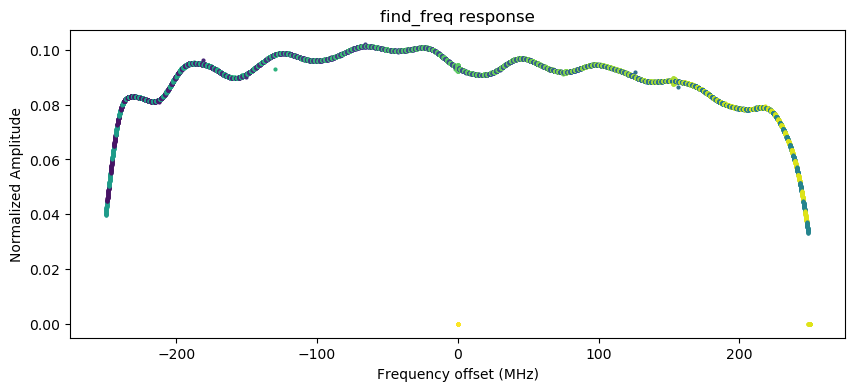

In [17]:
for band in bands:
    freqs, resps = S.find_freq(band, tone_power=12,grad_cut=0.01, amp_cut=0.1,make_plot=True,show_plot=True)
    

Hm band 0 is bad but I think it's because I failed to carry over the iq swap in the pysmurf cfg.  Let's try just band 2.

[ 2024-08-06 23:08:37 ]  Sweeping across frequencies 5000.0MHz to 5500.0MHz
[ 2024-08-06 23:08:37 ]  Working on band 2
[ 2024-08-06 23:09:07 ]  serial find freq complete ; etaScanInProgress = 0


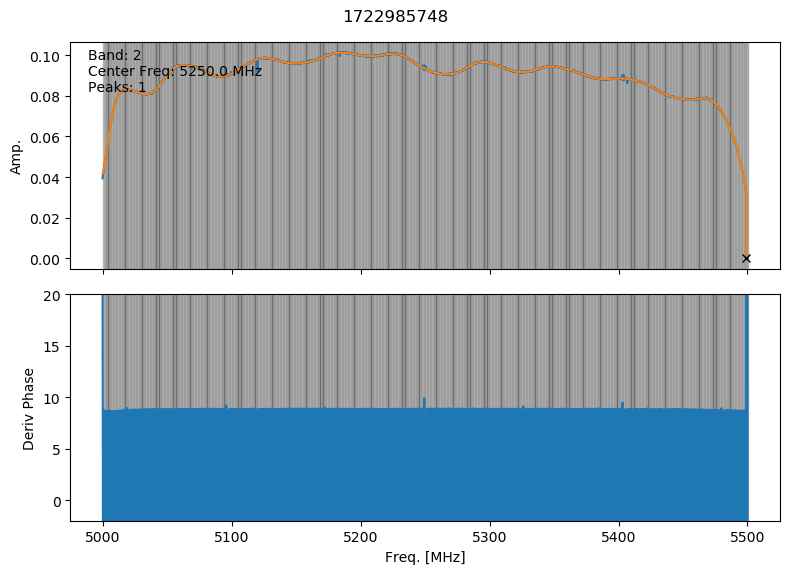

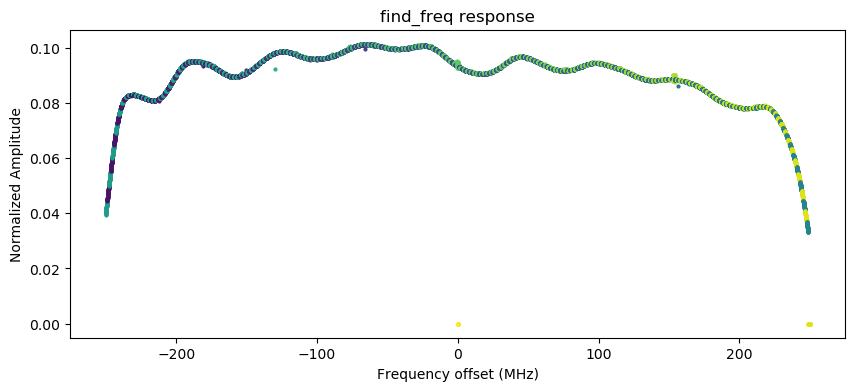

In [18]:
bands=[2]
for band in bands:
    freqs, resps = S.find_freq(band, tone_power=12,grad_cut=0.01, amp_cut=0.1,make_plot=True,show_plot=True)

Ok loopback good.  Let's connect back to DR and repeat.

[ 2024-08-06 23:10:40 ]  Sweeping across frequencies 5000.0MHz to 5500.0MHz
[ 2024-08-06 23:10:40 ]  Working on band 2
[ 2024-08-06 23:11:11 ]  serial find freq complete ; etaScanInProgress = 0


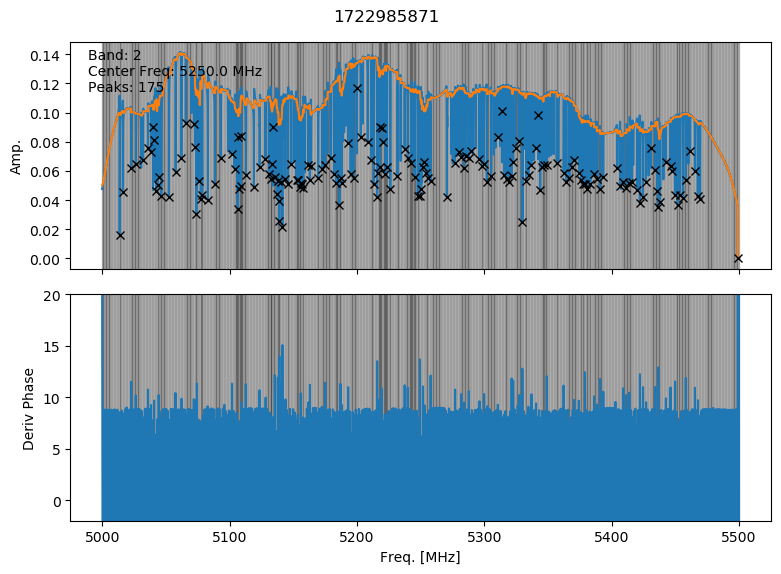

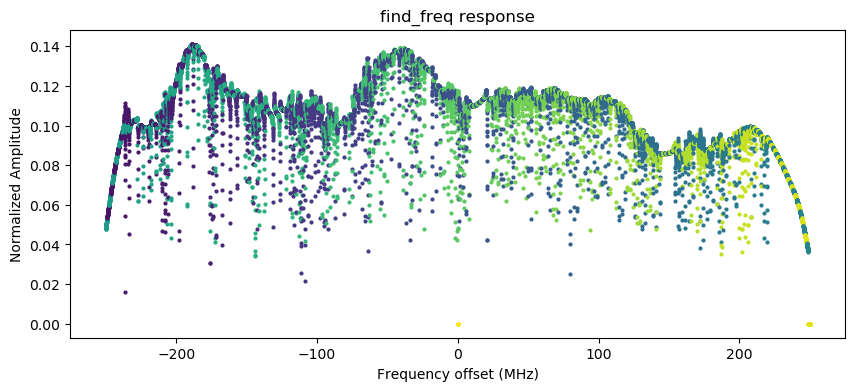

In [19]:
freqs, resps = S.find_freq(band, tone_power=12,grad_cut=0.01, amp_cut=0.1,make_plot=True,show_plot=True)

Scan a narrow range to just pick some resonators.

[ 2024-08-06 23:11:48 ]  Sweeping across frequencies 5200.0MHz to 5300.0MHz
[ 2024-08-06 23:11:48 ]  Working on band 2
[ 2024-08-06 23:11:56 ]  serial find freq complete ; etaScanInProgress = 0


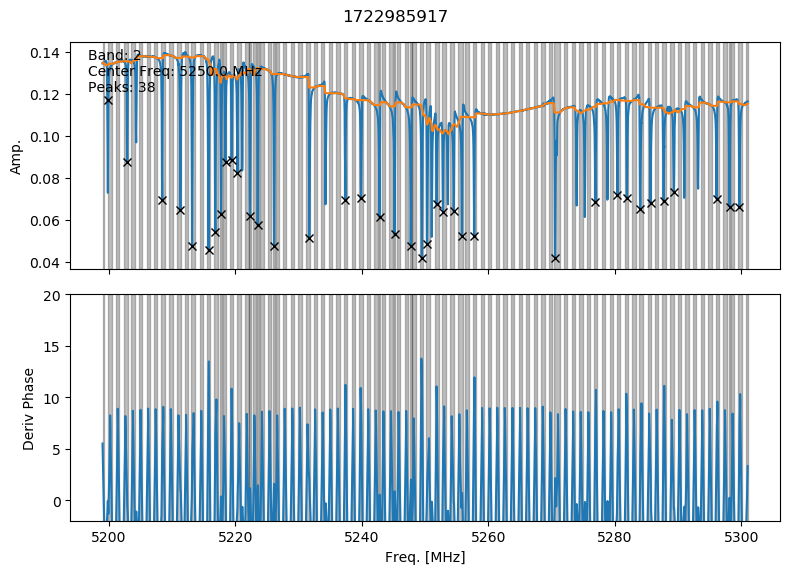

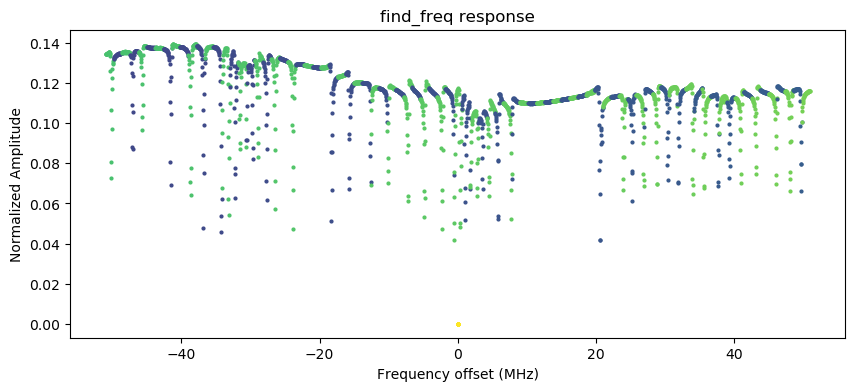

In [20]:
for band in bands:
    freqs, resps = S.find_freq(band=band, start_freq=-50, stop_freq=50, tone_power=12,grad_cut=0.01, amp_cut=0.1,make_plot=True,show_plot=True)

We need to manual the phase delay so let's zoom on just a few resonators to do that.

[ 2024-08-06 23:15:30 ]  Sweeping across frequencies 5245.0MHz to 5255.0MHz
[ 2024-08-06 23:15:30 ]  Working on band 2
[ 2024-08-06 23:15:33 ]  serial find freq complete ; etaScanInProgress = 0


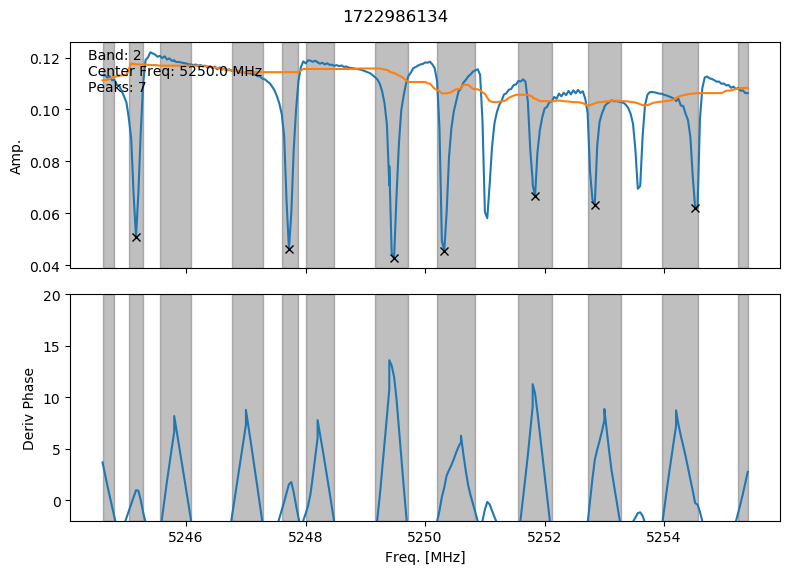

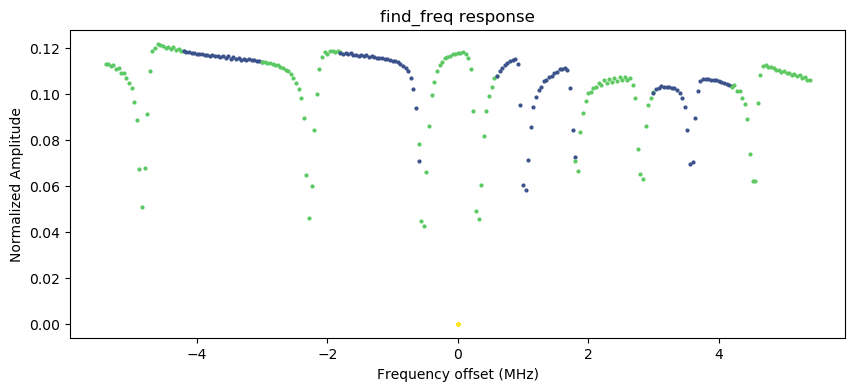

In [21]:
freqs, resps = S.find_freq(band=band, start_freq=-5, stop_freq=5, tone_power=12,grad_cut=0.01, amp_cut=0.1,make_plot=True,show_plot=True)

[ 2024-08-06 23:17:40 ]  No tone_power given. Using value in config file: 12
[ 2024-08-06 23:17:40 ]  freq 5245.1600 - 1 of 7
[ 2024-08-06 23:17:40 ]  freq 5247.7200 - 2 of 7
[ 2024-08-06 23:17:40 ]  freq 5249.4800 - 3 of 7
[ 2024-08-06 23:17:40 ]  freq 5250.3200 - 4 of 7
[ 2024-08-06 23:17:40 ]  freq 5251.8400 - 5 of 7
[ 2024-08-06 23:17:40 ]  freq 5252.8400 - 6 of 7
[ 2024-08-06 23:17:40 ]  freq 5254.5200 - 7 of 7
[ 2024-08-06 23:17:40 ]  Writing new channel assignment to /data/smurf_data/tune/1722986261_channel_assignment_b2.txt
[ 2024-08-06 23:17:40 ]  Old master assignment file: /data/smurf_data/tune/1722986206_channel_assignment_b2.txt
[ 2024-08-06 23:17:40 ]  New master assignment file: /data/smurf_data/tune/1722986261_channel_assignment_b2.txt
[ 2024-08-06 23:17:46 ]  serial find freq complete ; etaScanInProgress = 0
[ 2024-08-06 23:17:47 ]  Assigning channels
[ 2024-08-06 23:17:47 ]  Writing new channel assignment to /data/smurf_data/tune/1722986268_channel_assignment_b2.txt
[

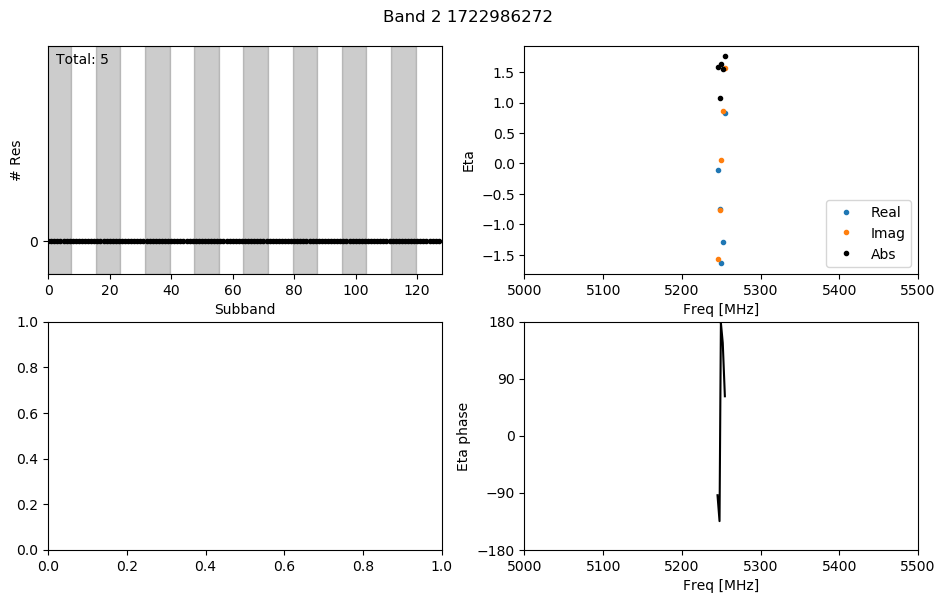

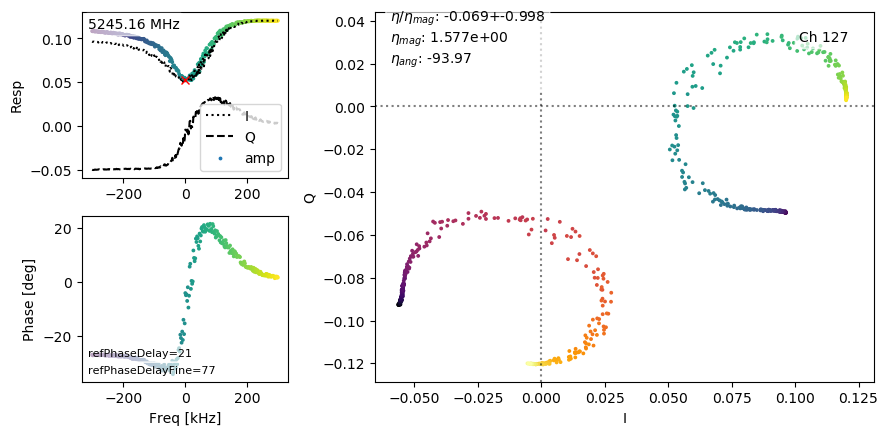

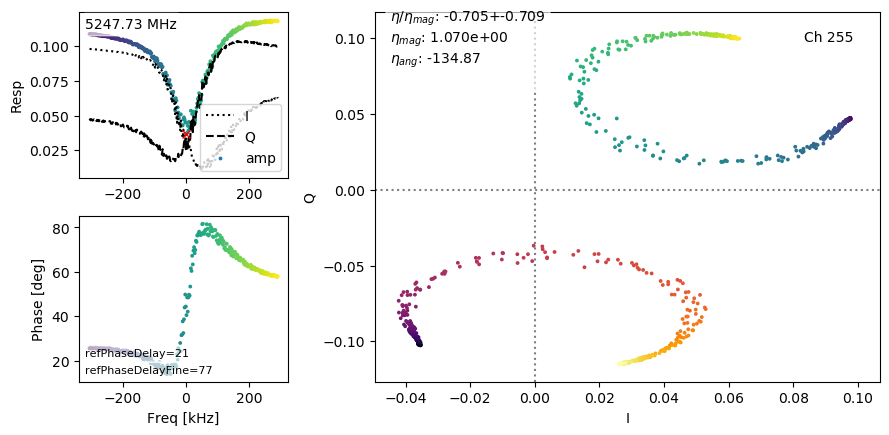

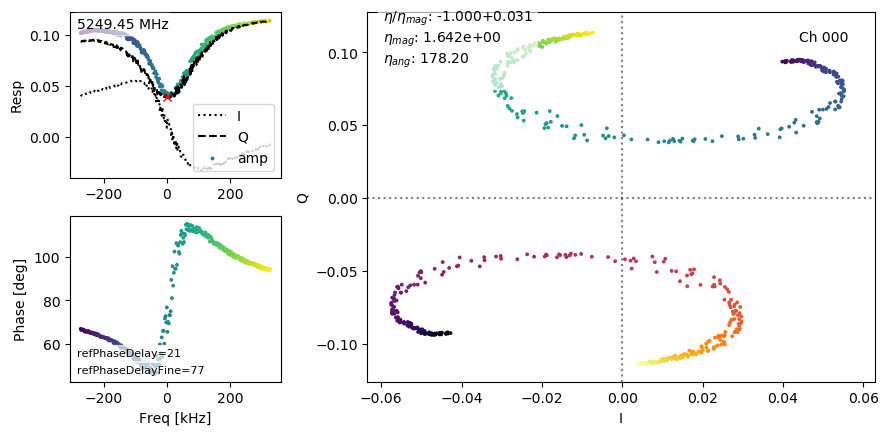

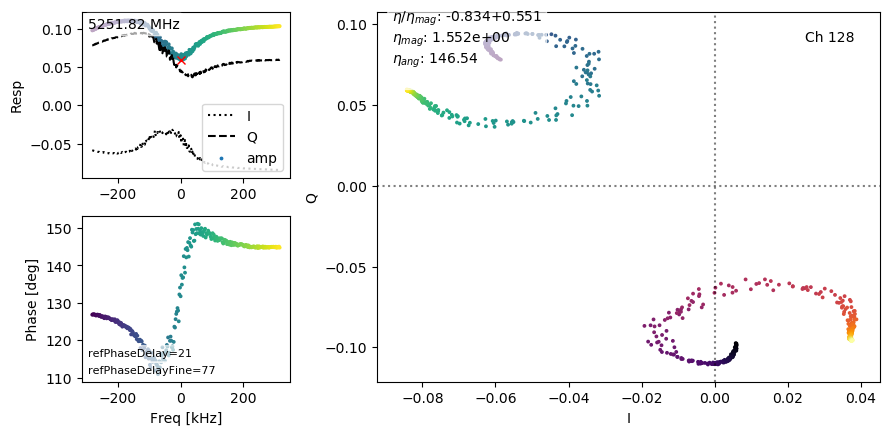

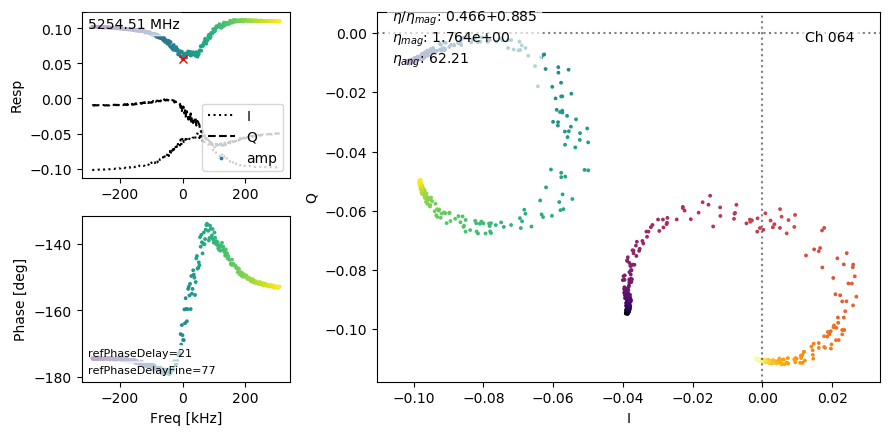

In [24]:
S.set_band_delay_us(band,8.5)
S.setup_notches(band,new_master_assignment=True)
S.plot_tune_summary(band,eta_scan=True,show_plot=True)

Oh!  Is AMC SMuRF flux ramp still on?  Try to turn it off.

In [26]:
Samc.flux_ramp_off()

Sweep frequencies again.

[ 2024-08-06 23:21:13 ]  Sweeping across frequencies 5245.0MHz to 5255.0MHz
[ 2024-08-06 23:21:13 ]  Working on band 2
[ 2024-08-06 23:21:17 ]  serial find freq complete ; etaScanInProgress = 0


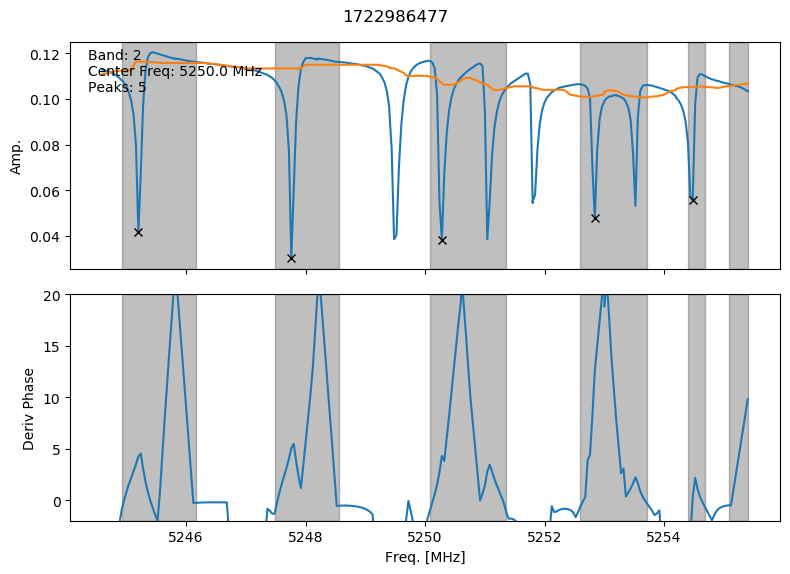

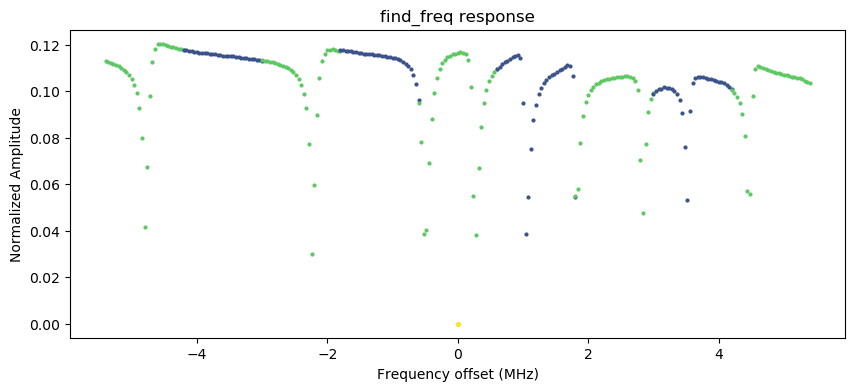

In [27]:
freqs, resps = S.find_freq(band=band, start_freq=-5, stop_freq=5, tone_power=12,grad_cut=0.01, amp_cut=0.1,make_plot=True,show_plot=True)

Try to calibrate phase delay again.

[ 2024-08-06 23:21:51 ]  No tone_power given. Using value in config file: 12
[ 2024-08-06 23:21:51 ]  freq 5245.2000 - 1 of 5
[ 2024-08-06 23:21:51 ]  freq 5247.7600 - 2 of 5
[ 2024-08-06 23:21:51 ]  freq 5250.2800 - 3 of 5
[ 2024-08-06 23:21:51 ]  freq 5252.8400 - 4 of 5
[ 2024-08-06 23:21:51 ]  freq 5254.4800 - 5 of 5
[ 2024-08-06 23:21:51 ]  Writing new channel assignment to /data/smurf_data/tune/1722986512_channel_assignment_b2.txt
[ 2024-08-06 23:21:51 ]  Old master assignment file: /data/smurf_data/tune/1722986268_channel_assignment_b2.txt
[ 2024-08-06 23:21:51 ]  New master assignment file: /data/smurf_data/tune/1722986512_channel_assignment_b2.txt
[ 2024-08-06 23:21:57 ]  serial find freq complete ; etaScanInProgress = 0
[ 2024-08-06 23:21:57 ]  Assigning channels
[ 2024-08-06 23:21:58 ]  Writing new channel assignment to /data/smurf_data/tune/1722986518_channel_assignment_b2.txt
[ 2024-08-06 23:21:58 ]  Old master assignment file: /data/smurf_data/tune/1722986512_channel_assig

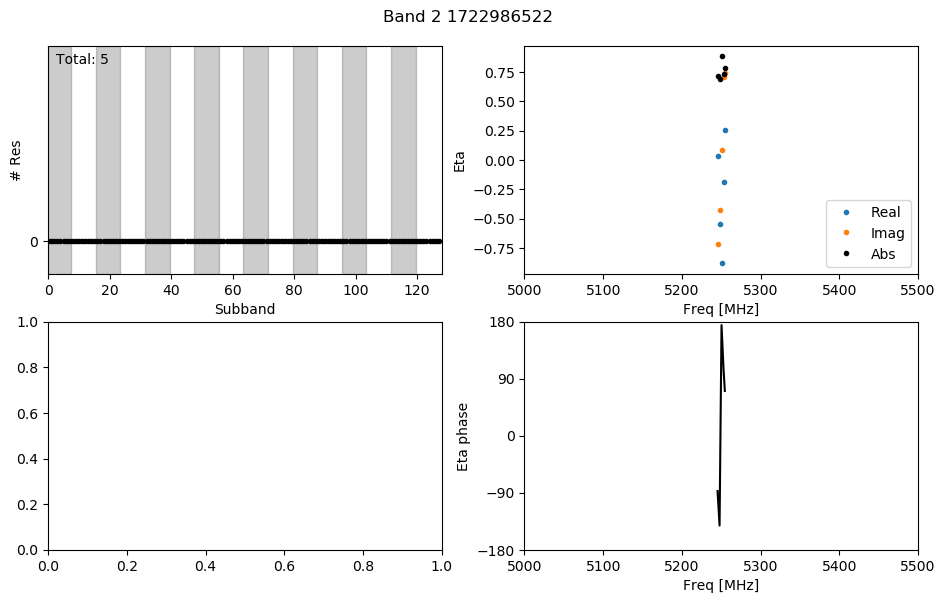

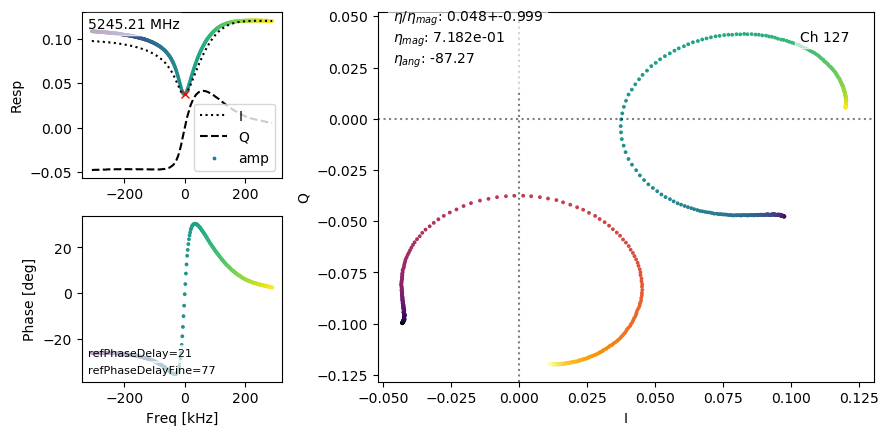

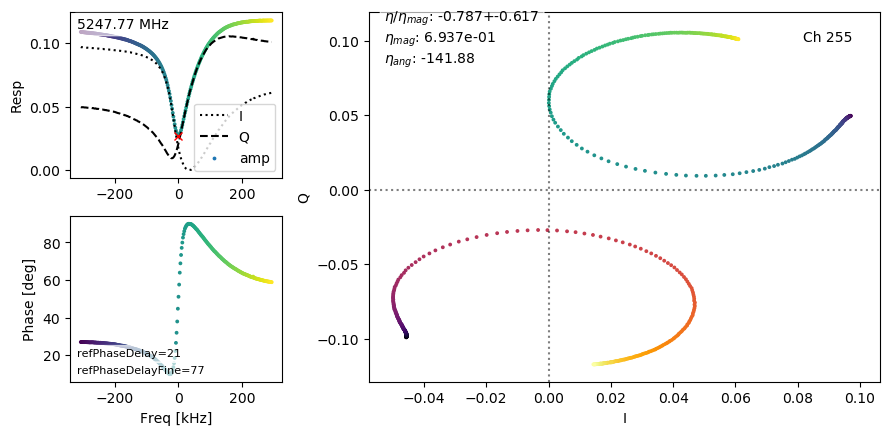

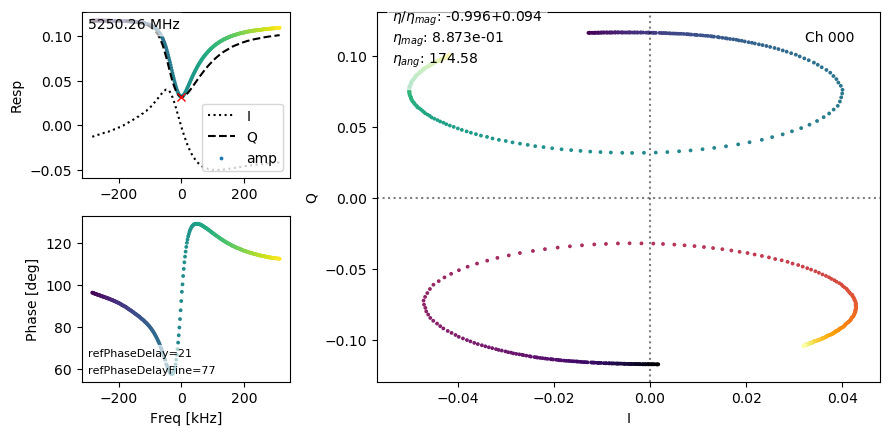

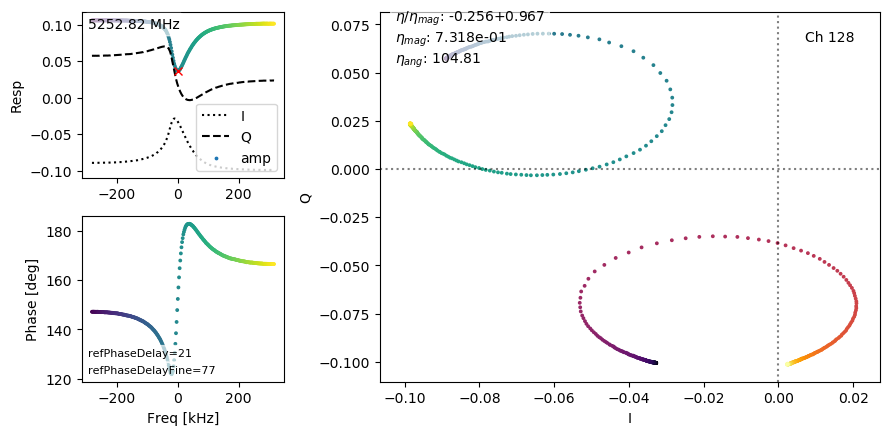

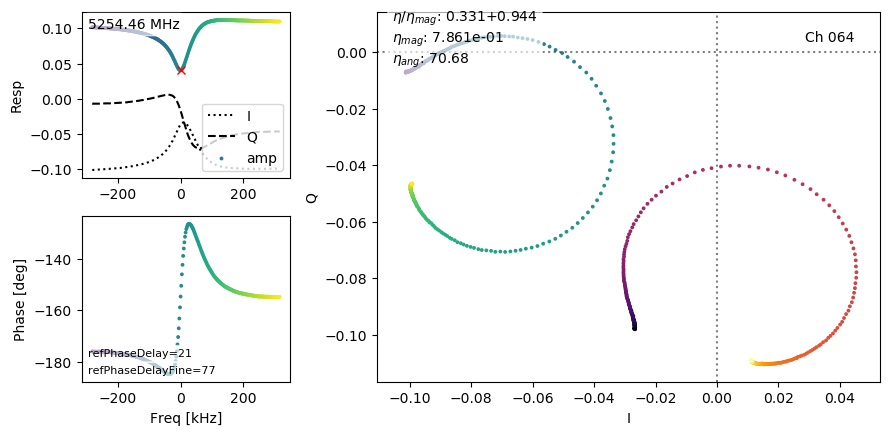

In [28]:
S.set_band_delay_us(band,8.5)
S.setup_notches(band,new_master_assignment=True)
S.plot_tune_summary(band,eta_scan=True,show_plot=True)

Refine the tune.

[ 2024-08-06 23:39:45 ]  No tone_power given. Using value in config file: 12
[ 2024-08-06 23:39:45 ]  freq 5245.2000 - 1 of 5
[ 2024-08-06 23:39:45 ]  freq 5247.7600 - 2 of 5
[ 2024-08-06 23:39:45 ]  freq 5250.2800 - 3 of 5
[ 2024-08-06 23:39:45 ]  freq 5252.8400 - 4 of 5
[ 2024-08-06 23:39:45 ]  freq 5254.4800 - 5 of 5
[ 2024-08-06 23:39:46 ]  Writing new channel assignment to /data/smurf_data/tune/1722987586_channel_assignment_b2.txt
[ 2024-08-06 23:39:46 ]  Old master assignment file: /data/smurf_data/tune/1722986707_channel_assignment_b2.txt
[ 2024-08-06 23:39:46 ]  New master assignment file: /data/smurf_data/tune/1722987586_channel_assignment_b2.txt
[ 2024-08-06 23:39:51 ]  serial find freq complete ; etaScanInProgress = 0
[ 2024-08-06 23:39:51 ]  Assigning channels
[ 2024-08-06 23:39:52 ]  Writing new channel assignment to /data/smurf_data/tune/1722987592_channel_assignment_b2.txt
[ 2024-08-06 23:39:52 ]  Old master assignment file: /data/smurf_data/tune/1722987586_channel_assig

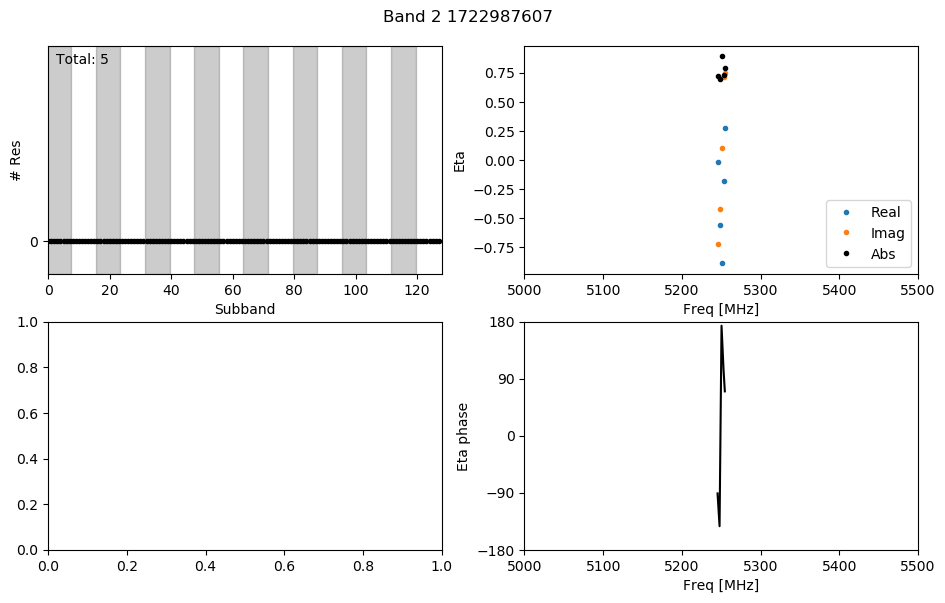

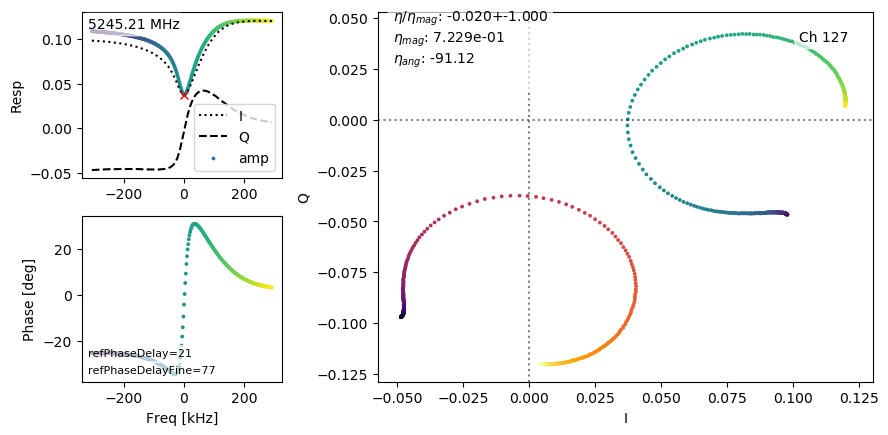

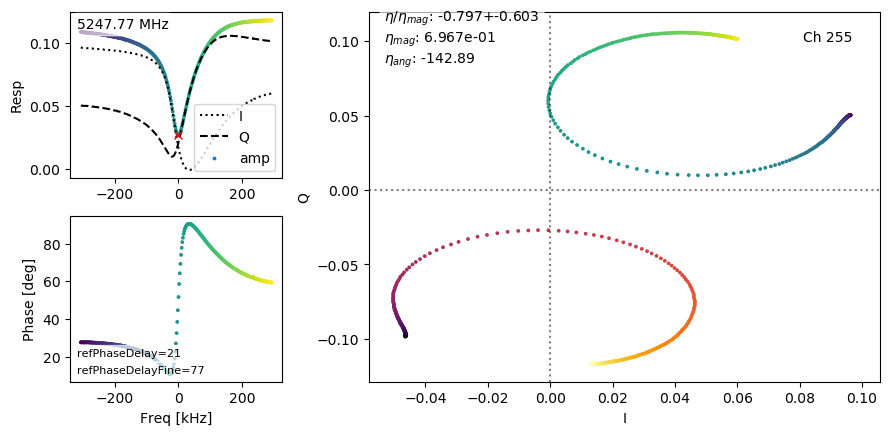

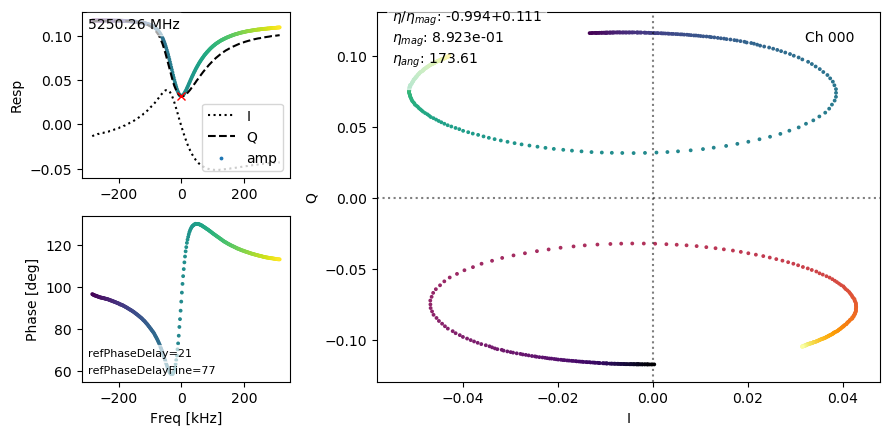

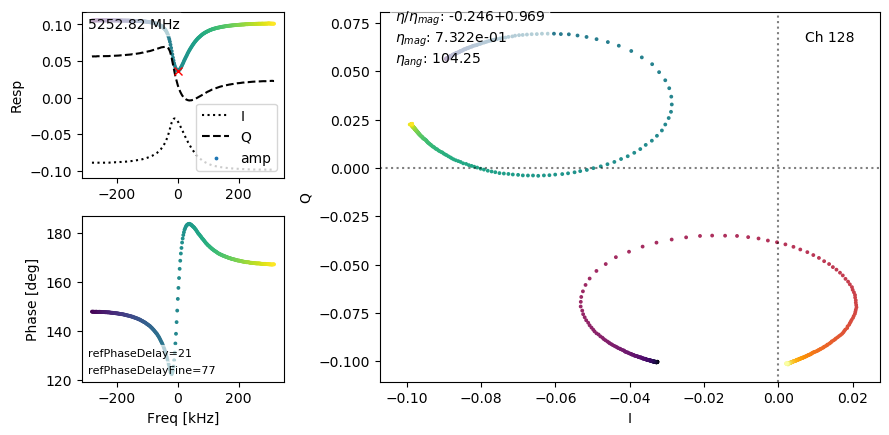

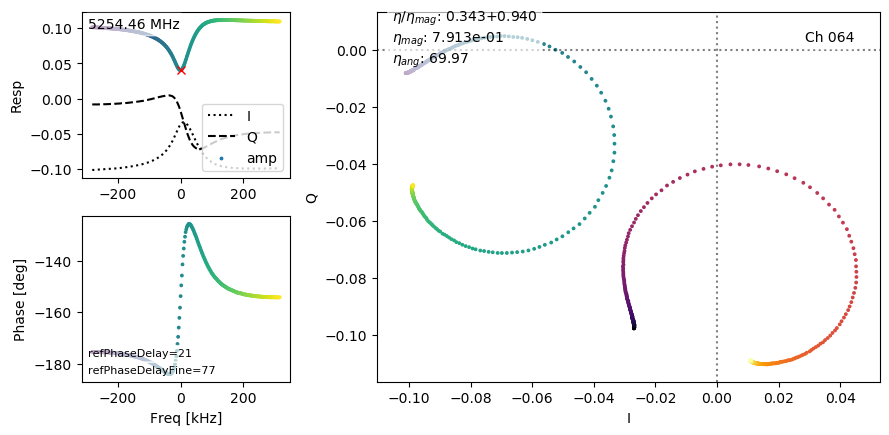

In [47]:
for band in bands:
    # Tune
    S.setup_notches(band,new_master_assignment=True)
    
    # Refine tuning
    S.run_serial_gradient_descent(band)
    
    # Refine eta calibrations
    S.run_serial_eta_scan(band)
    S.plot_tune_summary(band,eta_scan=True,show_plot=True)

In [30]:
for band in bands:
    for chan in S.which_on(band):
        print(f'band={band} chan={chan} : {S.channel_to_freq(band,chan)}')

band=2 chan=0 : 5250.264009332657
band=2 chan=64 : 5254.461963272095
band=2 chan=127 : 5245.207965660095
band=2 chan=128 : 5252.822004461288
band=2 chan=255 : 5247.765964221955


Make sure to turn off feedback for the fixed tones and make sure it's center frequency is zero.

In [31]:
for band in bands:
    print(len(S.which_on(band)))

5


Before moving on to tracking, let's make sure neither the ADC or DAC are saturated;

In [32]:
for band in bands:
    S.check_dac_saturation(band)
    S.check_adc_saturation(band)

[ 2024-08-06 23:25:55 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 4096
[ 2024-08-06 23:25:55 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 2
[ 2024-08-06 23:25:55 ]  DAC2 max count: 1772
[ 2024-08-06 23:25:55 ]  DAC2 min count: -1934
[ 2024-08-06 23:25:55 ]  DAC2 not saturated
[ 2024-08-06 23:25:55 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 4096
[ 2024-08-06 23:25:55 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 2
[ 2024-08-06 23:25:55 ]  ADC2 max count: 309
[ 2024-08-06 23:25:55 ]  ADC2 min count: -317
[ 2024-08-06 23:25:55 ]  ADC2 not saturated


Not clipping either the RF DAC or ADC.

## Tracking setup

Can we see modulation?

In [46]:
Samc.flux_ramp_off()

[ 2024-08-06 23:41:20 ]  Using LMS gain is now an advanced feature.
[ 2024-08-06 23:41:20 ]  Unless you are an expert, you probably want feedback_gain.
[ 2024-08-06 23:41:20 ]  See tracking_setup docstring.
[ 2024-08-06 23:41:20 ]  Starting fraction full scale : 0.489
[ 2024-08-06 23:41:20 ]  Percent full scale = 48.900%
[ 2024-08-06 23:41:20 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[2]:singleChannelReadout 0
[ 2024-08-06 23:41:20 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[2]:singleChannelReadoutOpt2 0
[ 2024-08-06 23:41:20 ]  Writing to file : /data/smurf_data/20240806/1722984589/outputs/1722987681.dat
[ 2024-08-06 23:41:20 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 524288
[ 2024-08-06 23:41:20 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 2
[ 2024-08-06 23:41:20 ]  Data acquisition in progress...
[ 2024-08-06 23:41:20 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:A

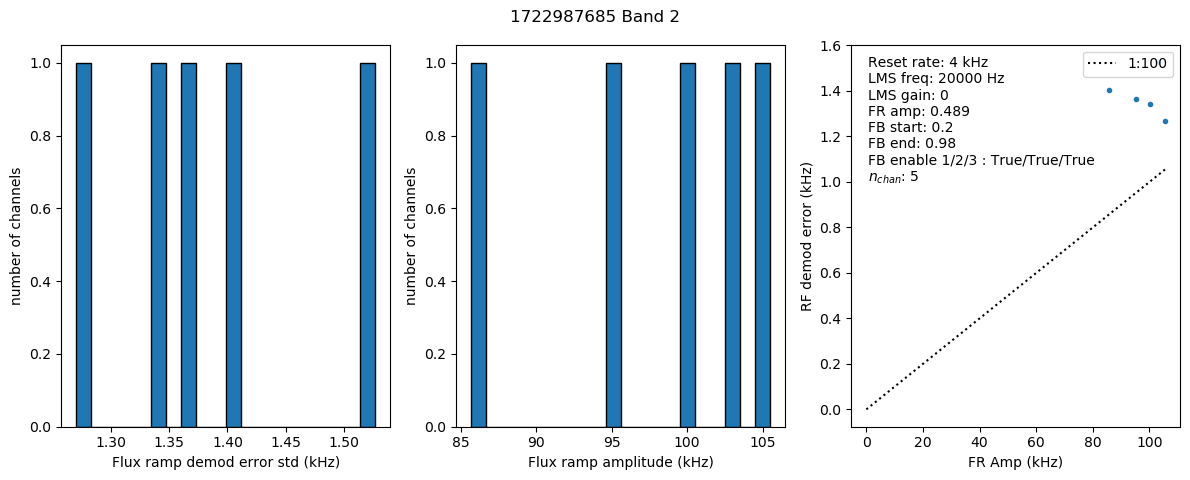

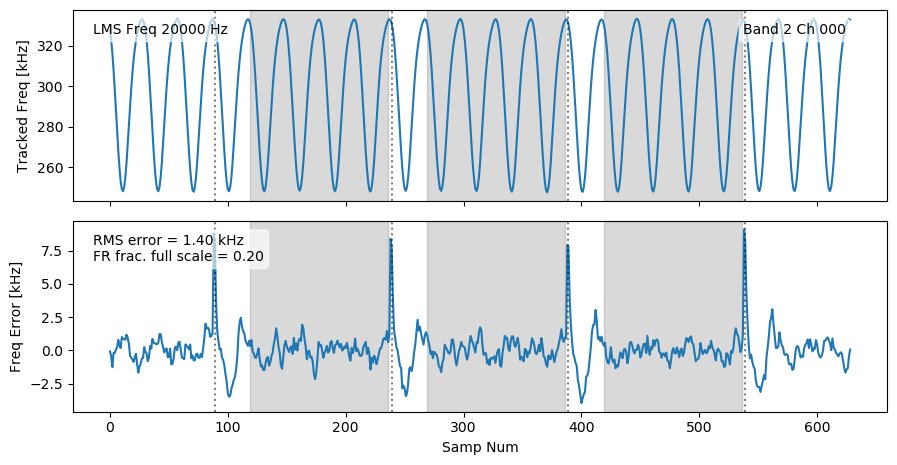

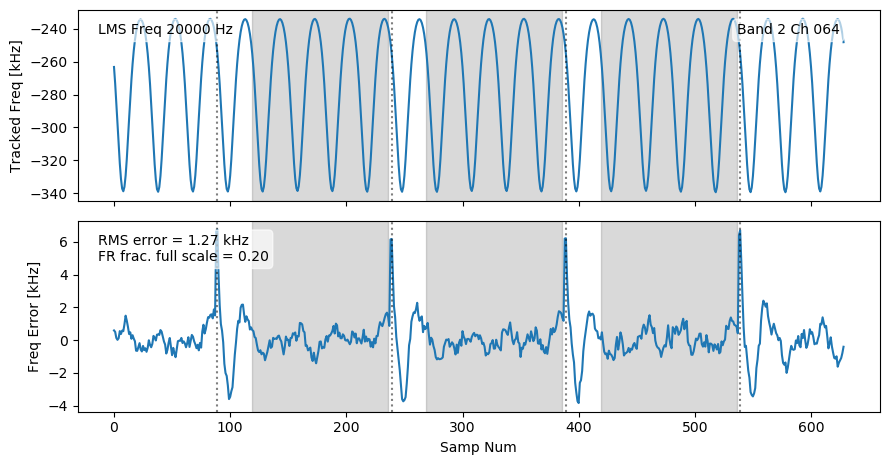

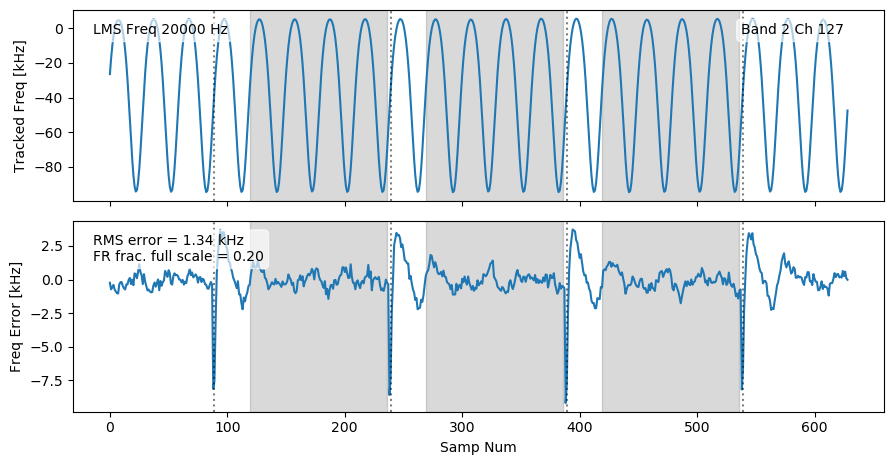

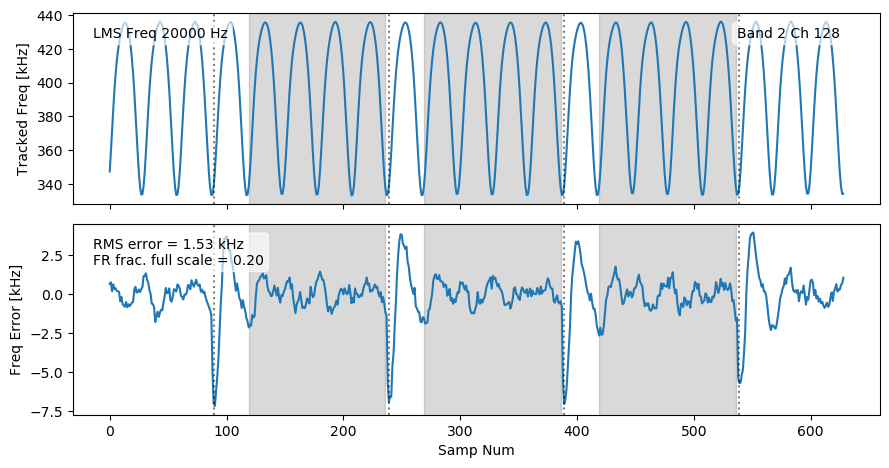

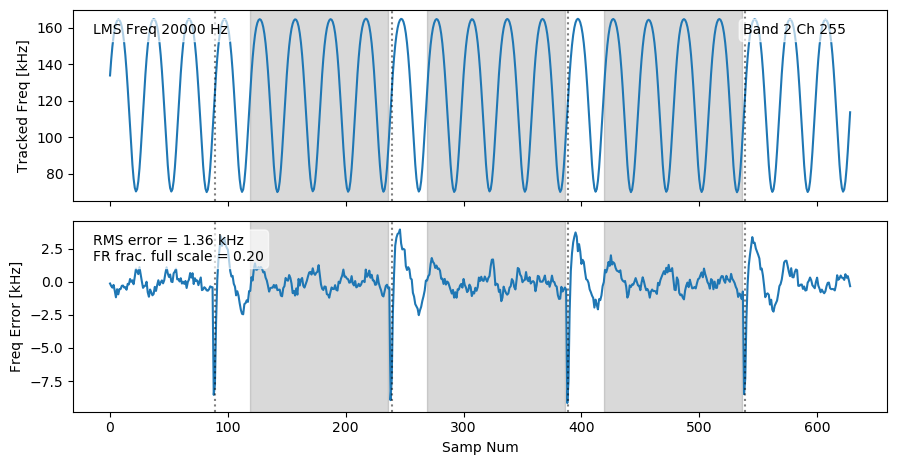

In [49]:
band=2
S.set_feedback_enable(band,1)
S.tracking_setup(band, channel = S.which_on(band), reset_rate_khz=4, make_plot=True, save_plot=True, show_plot=True, 
                  lms_freq_hz=None, n_phi0=5, meas_flux_ramp_amp=True, fraction_full_scale=0.2,feedback_gain=2048,lms_gain=0,
                  return_data=False, feedback_start_frac=0.2, feedback_end_frac=0.98,nsamp = 2**18, new_epics_root='smurf_server_s4')

Uh what...WHAT

## Take noise data

First time trying to take noise w/ RFSoC SMuRF WHAT'S GOING TO HAPPEN YES

[ 2024-08-06 23:43:35 ]  Starting to take data.
[ 2024-08-06 23:43:35 ]  Input downsample factor is None. Using value already in pyrogue: 20
[ 2024-08-06 23:43:35 ]  Flux ramp is AC-coupled.
[ 2024-08-06 23:43:37 ]  caput smurf_server_s3:AMCc:SmurfProcessor:Unwrapper:reset 1
[ 2024-08-06 23:43:37 ]  caput smurf_server_s3:AMCc:SmurfProcessor:Filter:reset 1
[ 2024-08-06 23:43:37 ]  Writing to file : /data/smurf_data/20240806/1722984589/outputs/1722987818.dat
[ 2024-08-06 23:43:37 ]  /data/smurf_data/20240806/1722984589/outputs/1722987818_mask.txt
[ 2024-08-06 23:43:37 ]  Writing frequency mask.
[ 2024-08-06 23:43:37 ]  caput smurf_server_s3:AMCc:SmurfProcessor:FileWriter:Open 1
[ 2024-08-06 23:44:37 ]  caput smurf_server_s3:AMCc:SmurfProcessor:FileWriter:Close 1
[ 2024-08-06 23:44:37 ]  caput smurf_server_s3:AMCc:FpgaTopLevel:AppTop:AppCore:enableStreaming 0
[ 2024-08-06 23:44:37 ]  Waiting 0.15 seconds after...
[ 2024-08-06 23:44:38 ]  Done waiting.
[ 2024-08-06 23:44:38 ]  Done taking 

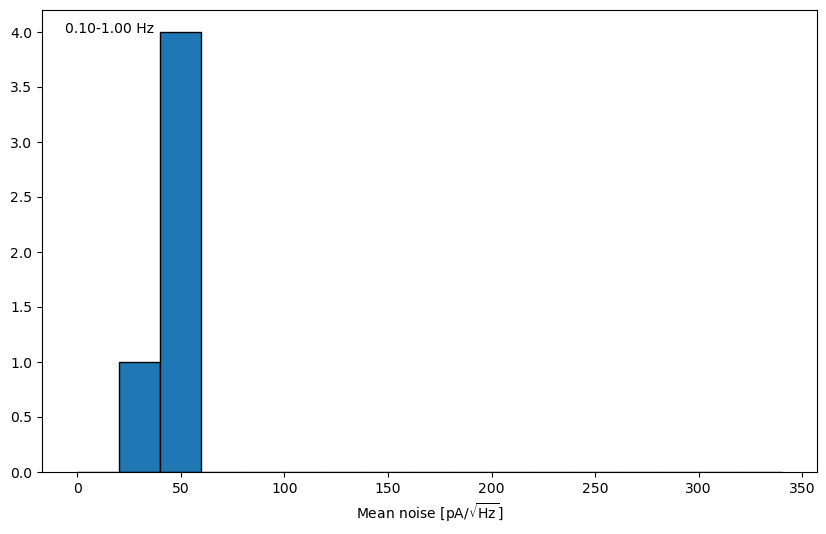

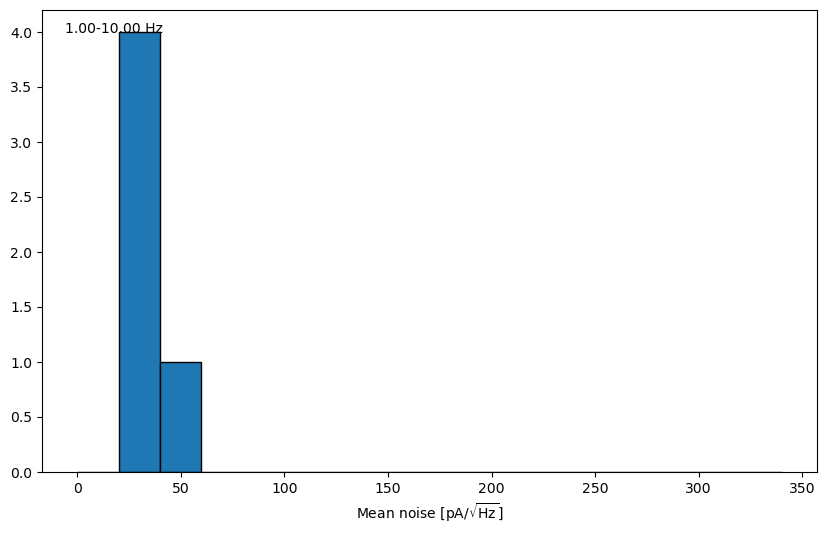

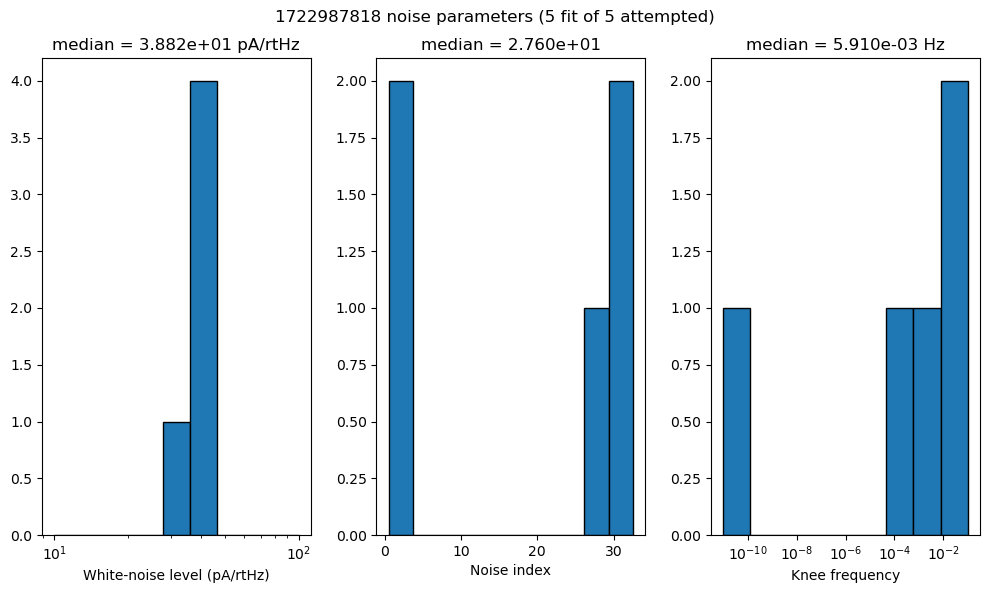

'/data/smurf_data/20240806/1722984589/outputs/1722987818.dat'

In [53]:
S.take_noise_psd(60,show_plot=True)

Here's a hack for looking at individual timestream plots; first one on SMB that's dark;

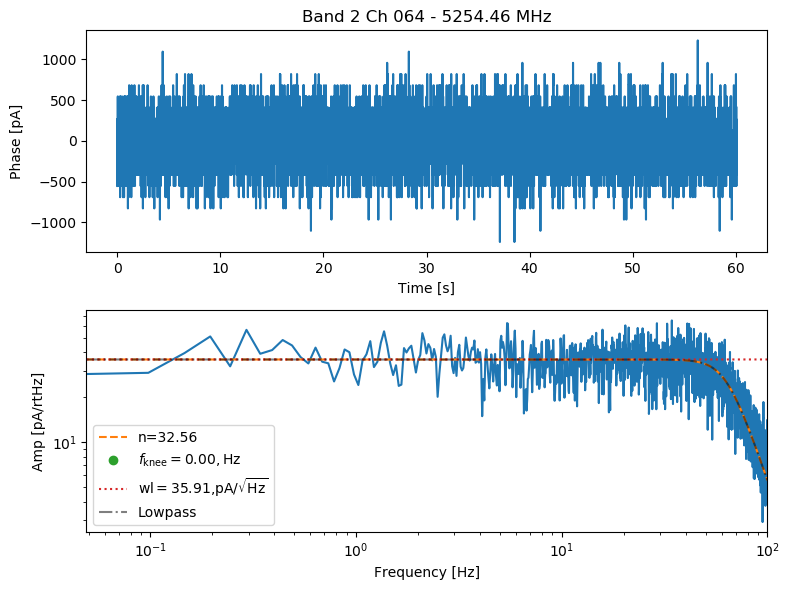

In [55]:
#Import library
from IPython.display import Image
# Load image from local storage
plt.ion()

Image(filename = "/data/smurf_data/20240806/1722984589/plots/1722987818_noise_timestream_b2_ch064.png", width = 600, height = 300)